Import the necessary packages

In [1]:
using Lux
using NaNMath
using SciMLSensitivity
using DiffEqFlux
using DifferentialEquations
using Plots
using Zygote
using Random
rng = Random.seed!(1234)
using OptimizationOptimisers
using Statistics
using ComponentArrays
using CUDA
ArrayType = CUDA.functional() ? CuArray : Array

Array

Import our custom backend functions

In [2]:
include("coupling_functions/functions_example.jl")
include("coupling_functions/functions_NODE.jl")
include("coupling_functions/functions_loss.jl")

loss_MulDtO_oneset (generic function with 1 method)

We are studying a phenomenon that can be described with the following ODE problem $$\dfrac{dP}{dt} = rP\left(1-\dfrac{P}{K}\right),$$ which is called the logistic equation. Given $P(t=0)=P_0$ we can solve this problem analytically to get $P(t) = \frac{K}{1+\left(K-P_0\right)/P_0 \cdot e^{-rt}}$. Let's plot the solution for $r=K=2, P_0=0.01$:

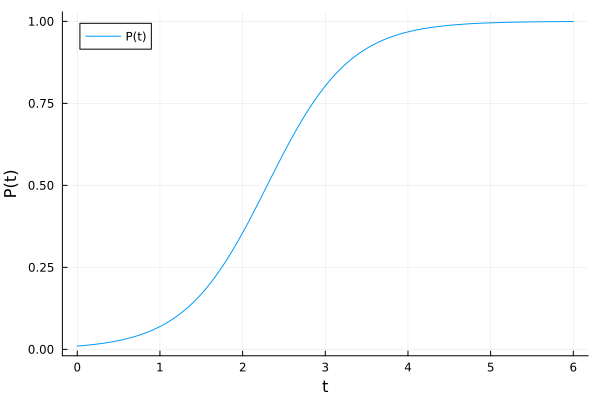

In [3]:
r=2
K=1
P0=0.01
function P(t)
    return K/(1+(K-P0)*exp(-r*t)/P0)
end
t = range(start=0, stop=6, step=0.01)
Pt = P.(t)
plot(t, Pt, label="P(t)", xlabel="t", ylabel="P(t)")

Now, let's say that we want to use the logistic equation to model an experiment like the activation energy of a neuron. We run the experiment and we observe the following:

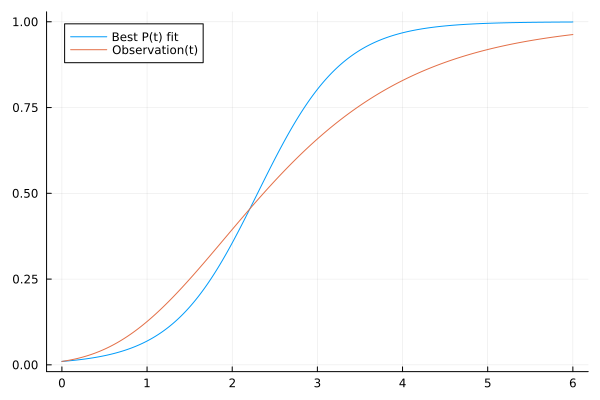

In [4]:
u_experiment = observation.()
plot(t, Pt, label="Best P(t) fit")
plot!(t, u_experiment[:], label="Observation(t)")

This means that our experimental system, despite its similarity, it is not described by a logistic ODE.
How can we then model our experiment as an ODE?

There are many simpler alternatives for this example (like Mode Decomposition, SINDY or Bayesian methods), but let's use this exercise to introduce a NODE:
\begin{equation}\dfrac{du}{dt} = \underbrace{ru\left(1-\dfrac{u}{K}\right)}_{f(u)} + NN(u|\theta).\end{equation}
In this NODE we are looking for a solution $u(t)$ that reproduces our observation.

We solve this simple 1d NODE using introducing the functionalities of this repository:

* We create the NN using `Lux`. In this example we do not discuss the structure of the NN, but we leave it as a black box that can be designed by the user. We will show later how to take inspiration from the physics of the problem to design optimal NN.

In [5]:
NN = create_nn()

SkipConnection(
    Dense(1 => 3),                      # 6 parameters
    #9
)         # Total: 6 parameters,
          #        plus 0 states.

* We define the force $f(u)$ compatibly with SciML.

In [6]:
f_u(u) = @. r*u*(1.0-u/K)

f_u (generic function with 1 method)

* We create the right hand side of the NODE, by combining the NN with f_u

In [7]:
f_NODE = create_f_NODE(NN, f_u; is_closed=true)

SkipConnection(
    SkipConnection(
        Dense(1 => 3),                  # 6 parameters
        #9
    ),
    #17
)         # Total: 6 parameters,
          #        plus 0 states.

and get the parametrs that you want to train

In [8]:
θ, st = Lux.setup(rng, f_NODE)

((weight = Float32[0.5540728; -0.42626837; -0.47275627;;], bias = Float32[0.0; 0.0; 0.0;;]), NamedTuple())

* We define the NODE

In [9]:
trange = (0.0f0, 6.0f0)
u0 = [0.01]
full_NODE = NeuralODE(f_NODE, trange, Tsit5(), adaptive=false, dt=0.001, saveat=0.2)

NeuralODE(
    model = SkipConnection(
        SkipConnection(
            Dense(1 => 3),              # 6 parameters
            #9
        ),
        #17
    ),
)         # Total: 6 parameters,
          #        plus 0 states.

we also solve it, using the zero-initialized parameters

In [10]:
untrained_NODE_solution = Array(full_NODE(u0, θ, st)[1])

1×31 Matrix{Float64}:
 0.01  0.0149412  0.0223251  0.0333488  …  1.04555  1.04558  1.0456  1.04561

We now start training the model. The first thing we have to do is to design the **loss function**. For this example, we use *multishooting a posteriori* fitting (MulDtO), where we tell `Zygote` to compare `nintervals` of length `nunroll` to get the gradient. Notice that this method is differentiating through the solution of the NODE!

In [11]:
nunroll = 60
nintervals = 10
myloss = create_randloss_MulDtO(u_experiment, nunroll=nunroll, nintervals=nintervals);

We also define this auxiliary NODE that will be used for training

In [12]:
dt = 0.01 # it has to be as fine as the data
t_train_range = (0.0f0, dt*(nunroll+1)) # it has to be as long as unroll
training_NODE = NeuralODE(f_NODE, t_train_range, Tsit5(), adaptive=false, dt=dt, saveat=dt)

NeuralODE(
    model = SkipConnection(
        SkipConnection(
            Dense(1 => 3),              # 6 parameters
            #9
        ),
        #17
    ),
)         # Total: 6 parameters,
          #        plus 0 states.

To initialize the training, we need some objects to monitor the procedure, and we trigger the first compilation.

In [13]:
lhist = Float32[]

Float32[]

Initialize and trigger the compilation of the model

In [14]:
pinit = ComponentArray(θ)
myloss(pinit)  # trigger compilation

(1072.197486812303, nothing)

Select the autodifferentiation type

In [15]:
adtype = Optimization.AutoZygote()

AutoZygote()

We transform the NeuralODE into an optimization problem

In [16]:
optf = Optimization.OptimizationFunction((x, p) -> myloss(x), adtype);
optprob = Optimization.OptimizationProblem(optf, pinit);

Select the training algorithm:
we choose Adam with learning rate 0.1, with gradient clipping

In [17]:
ClipAdam = OptimiserChain(Adam(1.0f-1), ClipGrad(1));

Finally we can train the NODE

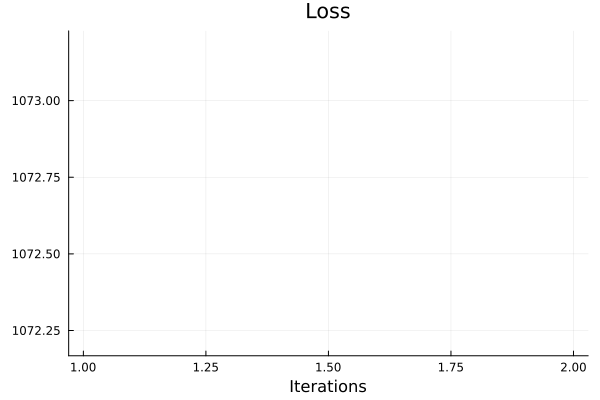

Loss[0]: 1072.197486812303


Loss[1]: 467.7102951697957


Loss[2]: 459.23737684375556


Loss[3]: 642.5061069878547


Loss[4]: 624.8801957072455


Loss[5]: 510.271409636268


Loss[6]: 411.3299110617665


Loss[7]: 385.3405732714324


Loss[8]: 430.3993329228923


Loss[9]: 477.27893657963926


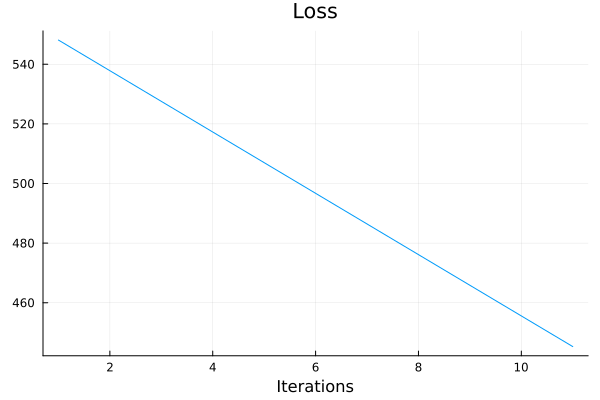

Loss[10]: 445.2919989703049


Loss[11]: 364.66239754629913


Loss[12]: 324.4018450257045


Loss[13]: 342.01984983234064


Loss[14]: 362.54452921787845


Loss[15]: 349.71233109262727


Loss[16]: 311.82889464077516


Loss[17]: 286.62733881661484


Loss[18]: 300.7942970266531


Loss[19]: 295.447147996823


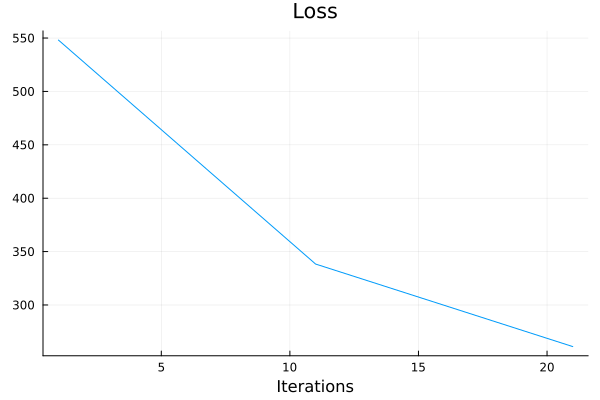

Loss[20]: 261.027482025955


Loss[21]: 259.91067462028684


Loss[22]: 259.5067377207684


Loss[23]: 228.6857917590038


Loss[24]: 223.42278931712605


Loss[25]: 221.3391268304645


Loss[26]: 203.44399587642087


Loss[27]: 211.43390351750585


Loss[28]: 180.35484093672187


Loss[29]: 179.9931589037536


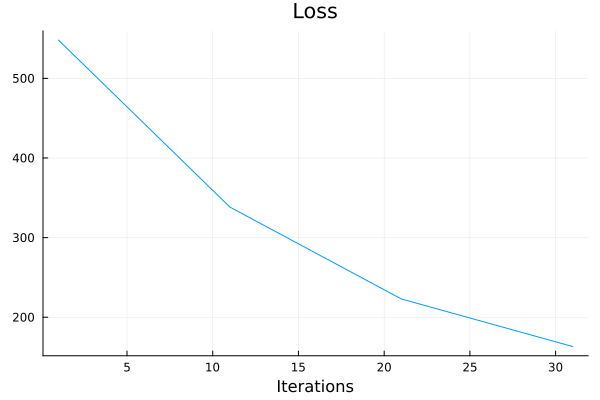

Loss[30]: 163.096561200454


Loss[31]: 159.06240511104534


Loss[32]: 145.1942168472216


Loss[33]: 136.33838800208179


Loss[34]: 117.88495242259734


Loss[35]: 110.73591390300147


Loss[36]: 91.04971194771767


Loss[37]: 77.94334561479108


Loss[38]: 100.37433567468875


Loss[39]: 84.61896180201515


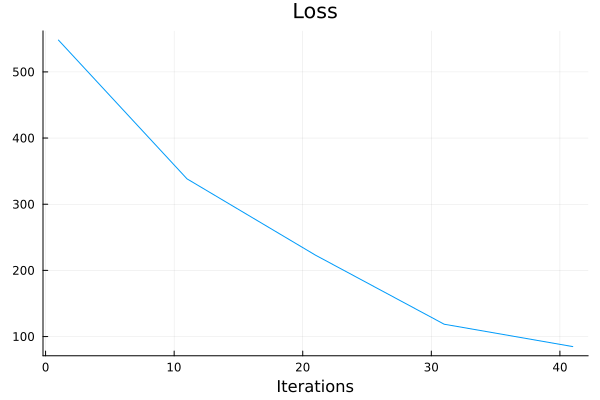

Loss[40]: 84.81387519183438


Loss[41]: 47.75098617408369


Loss[42]: 113.58219191454931


Loss[43]: 67.6861169865381


Loss[44]: 184.0860059965632


Loss[45]: 160.7046825422142


Loss[46]: 83.11906211616216


Loss[47]: 138.5177913394997


Loss[48]: 59.38674471202323


Loss[49]: 147.27516363313833


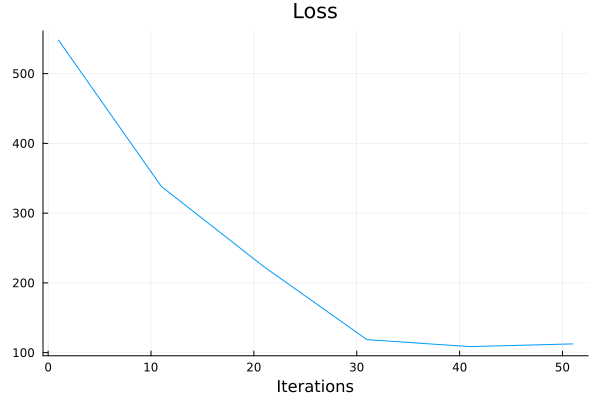

Loss[50]: 112.5608765274435


Loss[51]: 121.0291961914366


Loss[52]: 134.796562803925


Loss[53]: 75.85094529792168


Loss[54]: 137.7023371114663


Loss[55]: 68.47165290391732


Loss[56]: 133.14911120454616


Loss[57]: 145.75849460026114


Loss[58]: 63.56821074186504


Loss[59]: 142.41701227362176


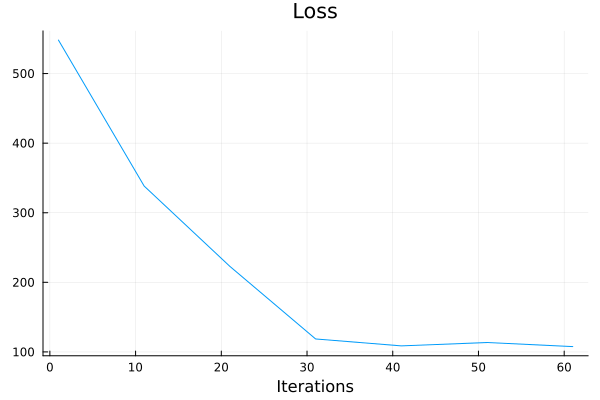

Loss[60]: 107.65591018170359


Loss[61]: 107.68264802378296


Loss[62]: 138.40421850840858


Loss[63]: 66.65423485451406


Loss[64]: 118.36420531787357


Loss[65]: 97.03524377037398


Loss[66]: 90.12018583443064


Loss[67]: 115.57639305375919


Loss[68]: 62.10226812862511


Loss[69]: 86.08862483191797


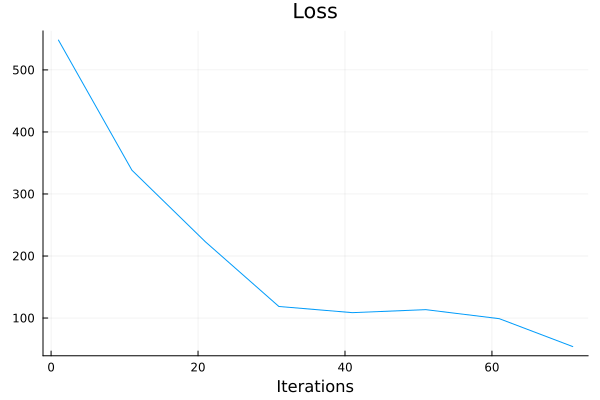

Loss[70]: 53.965359087952024


Loss[71]: 87.47788315367195


Loss[72]: 51.81942290027154


Loss[73]: 74.03569820847525


Loss[74]: 74.8846587696971


Loss[75]: 64.4985965752032


Loss[76]: 67.66103483036945


Loss[77]: 55.048550941529


Loss[78]: 70.70858761350374


Loss[79]: 58.14226333859019


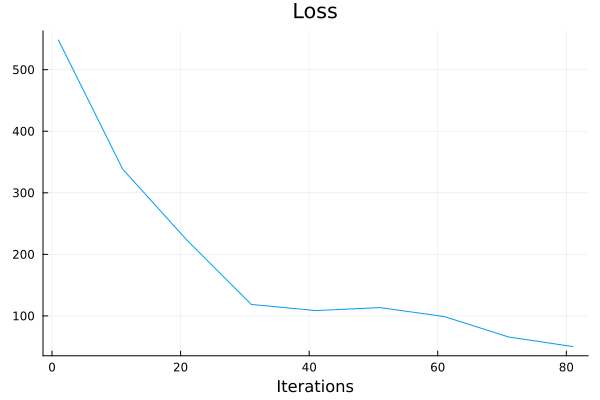

Loss[80]: 50.16365749579944


Loss[81]: 50.95123564683649


Loss[82]: 43.21726464097399


Loss[83]: 55.30422516693261


Loss[84]: 43.132836959057066


Loss[85]: 38.4860716596386


Loss[86]: 53.153896278921266


Loss[87]: 47.358877485196764


Loss[88]: 46.61389926303551


Loss[89]: 59.68690288638443


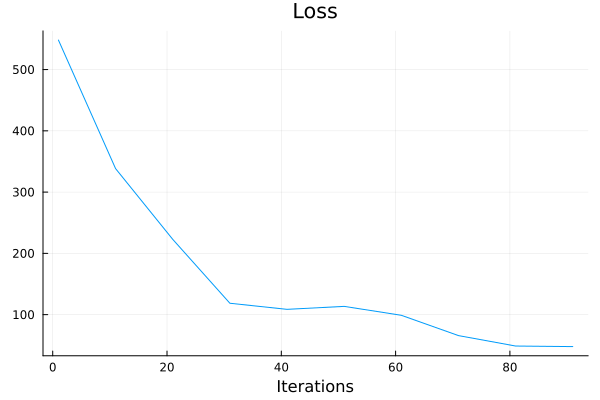

Loss[90]: 47.88678738769654


Loss[91]: 38.75846752561696


Loss[92]: 57.95306784773316


Loss[93]: 52.764584697247436


Loss[94]: 58.20395768715029


Loss[95]: 36.13147358866626


Loss[96]: 50.526749564283044


Loss[97]: 87.24256813181658


Loss[98]: 69.23383338596916


Loss[99]: 91.7626313124727


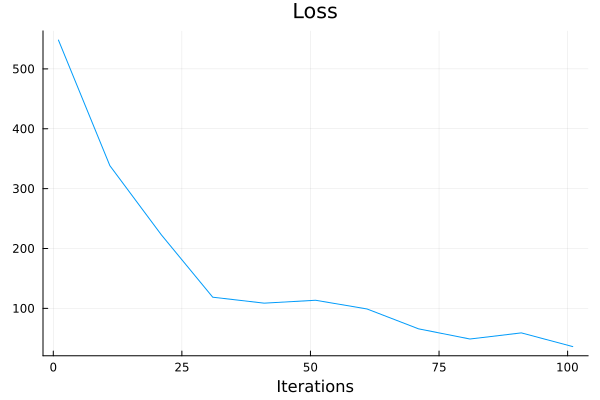

Loss[100]: 36.13147358866626


In [18]:
result_neuralode = Optimization.solve(optprob,
    ClipAdam;
    callback = callback,
    maxiters = 100
    )
pinit = result_neuralode.u
optprob = Optimization.OptimizationProblem(optf, pinit);

(This block can be repeated to continue training)

Those are the results that we get

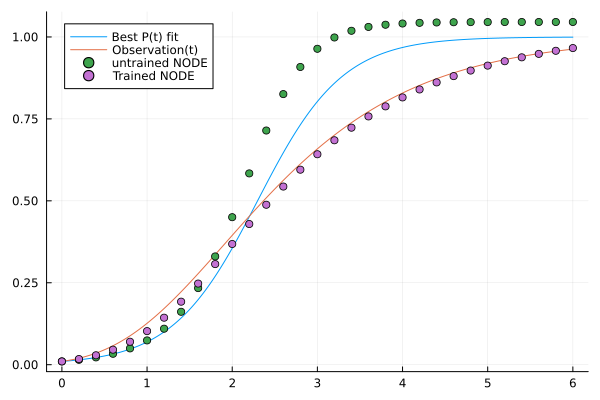

In [19]:
plot()
plot(t, Pt, label="Best P(t) fit")
plot!(t, u_experiment[:], label="Observation(t)")
scatter!(range(start=0, stop=6, step=0.2), untrained_NODE_solution[:], label="untrained NODE", marker=:circle)
scatter!(range(start=0, stop=6, step=0.2), Array(full_NODE([u_experiment[1]], result_neuralode.u, st)[1])[:], label="Trained NODE", marker=:circle)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*